In [53]:
import time

import jax
import jax.numpy as jnp
import diffrax

from rodas5 import Rodas5

In [54]:
mu = 1.0



def f(t, y, args):
    return jnp.array([
        y[1], 
        mu * args[0]**2 * jnp.exp(t) * (1 - y[0]**2)*y[1] - y[0]])



In [55]:
t0, t1 = 0.0, 3*mu
y0 = jnp.array([2., 0.])

maxsteps = 5000

N = 100

stepsize = t1/N
saveat = diffrax.SaveAt(ts=list(jnp.arange(t0, t1, stepsize)))

integrator = Rodas5()


In [56]:


rtol = 1e-3
atol = 1e-3

n_batch = 10

arg_batch = jnp.arange(1, n_batch + 1).reshape((n_batch, 1))
y0_batch = jnp.array([[k/10.0, 0.0] for k in range(n_batch)]).astype(float)

stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
term = diffrax.ODETerm(f)


def solve(y, args):
    return diffrax.diffeqsolve(term, 
                    integrator, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)

solve_vmap = jax.vmap(solve, (0, 0))
start = time.time()
solutions_vmap = solve_vmap(y0_batch, arg_batch)
end = time.time()

print("time: ", end-start)


/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  3.191673994064331


In [57]:

    
%timeit solve_vmap(y0_batch, arg_batch)


112 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
from rodas5batched import Rodas5Batched

integrator_batched = Rodas5Batched()

f_batched = jax.vmap(f, (None, 0 , 0))
term_batched = diffrax.ODETerm(f_batched)

# terms = [diffrax.ODETerm(f) for _ in range(n_batch)]

def solve_batch(y, args):
    return diffrax.diffeqsolve(term_batched, 
                    integrator_batched, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)

start = time.time()
solutions_batch = solve_batch(y0_batch, arg_batch)
end = time.time()

print("time: ", end-start)


/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Documents/Projects/VdP_batched_solve/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  2.4318861961364746


In [59]:
    
%timeit solve_batch(y0_batch, arg_batch)

133 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
jac_f_batched = jax.vmap(lambda _t, _y, _a: jax.jacobian(lambda __y: f(_t, __y, _a))(_y), (None, 0, 0))

y0_ident = 0.5*jnp.ones_like(y0_batch)

jac_blocks = jac_f_batched(1, y0_ident, arg_batch)

identity = jnp.eye(y0.shape[0])

lu_batched = jax.vmap(lambda a: jax.scipy.linalg.lu_factor(a - identity), (0,))

lu_and_pivs = lu_batched(jac_blocks)

jac_full = jax.scipy.linalg.block_diag(*jac_blocks)

In [61]:
dt_f_batched = jax.vmap(lambda _t, _y, _a: jax.jacobian(lambda __t: f(__t, _y, _a))(_t), (None, 0, 0)) 
dt_f_batched(1.0, y0_batch, arg_batch).shape

(10, 2)

In [62]:
solutions_vmap.ts.shape, solutions_batch.ts.shape

((10, 100), (100,))

In [63]:
solutions_vmap.ys.shape, solutions_batch.ys.shape

((10, 100, 2), (100, 10, 2))

In [64]:
batch_ys =  []
batch_ts = []
for k in range(n_batch):
    batch_ys.append(solutions_batch.ys[:,k])
    batch_ts.append(solutions_batch.ts)

batch_ys = jnp.array(batch_ys)
batch_ts = jnp.array(batch_ts)
batch_ys.shape, batch_ts.shape

((10, 100, 2), (10, 100))

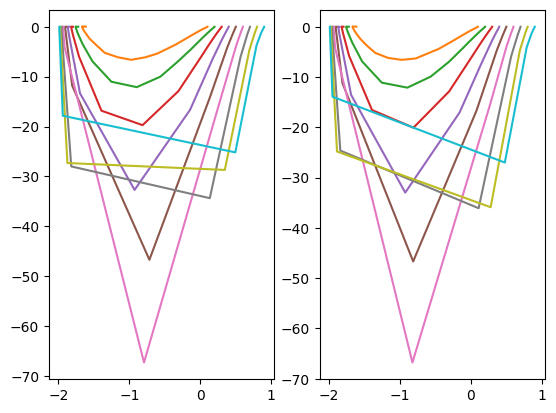

In [71]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

for solution in batch_ys:
    ax1.plot(solution[:,0], solution[:,1])

for solution in solutions_vmap.ys:
    ax2.plot(solution[:,0], solution[:,1])

In [66]:
for sol_batch, sol_vmap in zip(batch_ys, solutions_vmap.ys):
    print(sol_batch[-1], sol_vmap[-1])

[0. 0.] [0. 0.]
[-1.6143253  0.0130932] [-1.6143428   0.01306894]
[-1.7211969  0.0050207] [-1.7211815   0.00502848]
[-1.7960515   0.00250481] [-1.7959037   0.00248956]
[-1.8512036e+00  1.4620449e-03] [-1.8509015e+00  1.5359796e-03]
[-1.8934512e+00  9.4957300e-04] [-1.8934557e+00  8.9783617e-04]
[-1.9270602e+00  6.6416455e-04] [-1.9269789e+00  6.4603804e-04]
[-1.9527874e+00  4.9076503e-04] [-1.9528375e+00  4.9260742e-04]
[-1.9720371e+00  3.7796726e-04] [-1.9715981e+00  3.3383217e-04]
[-1.9846511e+00  3.0095357e-04] [-1.9846303e+00  2.6968663e-04]


In [67]:
last_vmap =  []
for k in range(n_batch):
    last_vmap.append(solutions_vmap.ys[k, :])

jnp.array(last_vmap) 

Array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 1.00000001e-01,  0.00000000e+00],
        [ 9.99531448e-02, -3.18887783e-03],
        [ 9.89869684e-02, -1.09749474e-02],
        ...,
        [-1.61523283e+00,  1.39125558e-02],
        [-1.61478782e+00,  1.34907495e-02],
        [-1.61434281e+00,  1.30689405e-02]],

       [[ 2.00000003e-01,  0.00000000e+00],
        [ 1.99901566e-01, -6.86691562e-03],
        [ 1.99089944e-01, -2.05859132e-02],
        ...,
        [-1.72151291e+00,  5.25302906e-03],
        [-1.72134721e+00,  5.14075626e-03],
        [-1.72118151e+00,  5.02848253e-03]],

       ...,

       [[ 6.99999988e-01,  0.00000000e+00],
        [ 6.99548364e-01, -3.60599793e-02],
        [ 6.93965435e-01, -2.57280052e-01],
        ...,
     